<br>
<section style="font-family:Times New Roman"><br>
    <strong style= "font-weight: bold; color:#0e1a40; font-size:35px;"><i>Backpack Prediction | EDA | XGB-Cat | Py</i></strong><br><br>
    <b style= "font-weight: bold; color:#000000; font-size:20px;"> By: <i>Kheirallah Samaha</i></b><br><br>
    <b style= "font-weight: bold; color:#000000; font-size:17px;"> Date: Feb-01-2025</b>
</section>

<div style="border-radius:10px; border:#a1d4d2 solid; padding: 15px; background-color: #ece9e5; font-size:100%; text-align:left">

<h3 align="left"><font color="#4E5672">&#128240; Data Description</font></h3>

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #ddd0d2; font-size:100%; text-align:left">

<h3 align="left"><font color="#4E5672">Understanding Data:</font></h3>

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Student Bag Price Prediction Dataset dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

**Files**    
train.csv - the training dataset; Price is the target   
test.csv - the test dataset; your objective is to predict the Price for each row   
sample_submission.csv - a sample submission file in the correct format.   

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color: #000000; font-size:30px; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Import libraries</p>

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
SEED = 1
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [2]:
# Load thg Data
train_df = pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv").drop(columns=["id"],axis=1)
test_df = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv").drop("id",axis=1)
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e2/sample_submission.csv")

<p style="background-color:#ece9e5; font-family:newtimeroman;color:#602F44; font-size:30px; text-align:left; border-radius: 5px 5px"> &#128201  EDA: Understanding the Patterns!</p>


In [3]:
def analyze_dataframe(df):

    print("DataFrame Information:")
    print("----------------------")
    display(df.info(verbose=True, show_counts=True))
    print("\n")

    print("DataFrame Values (head(5).T):")
    print("----------------------")
    display(df.head(5).T)
    print("\n")

    print("DataFrame Description:")
    print("----------------------")
    display(df.describe(include="all").T)
    print("\n")

    print("Number of Null Values:")
    print("----------------------")
    display(df.isnull().sum())
    print("\n")

    print("Number of Duplicated Rows:")
    print("--------------------------")
    display(df.duplicated().sum())
    print("\n")

    print("Number of Unique Values:")
    print("------------------------")
    display(df.nunique())
    print("\n")


    print("DataFrame Shape:")
    print("----------------")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

analyze_dataframe(train_df)

DataFrame Information:
----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694318 entries, 0 to 3694317
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Brand                 3577265 non-null  object 
 1   Material              3591703 non-null  object 
 2   Size                  3613128 non-null  object 
 3   Compartments          3694318 non-null  float64
 4   Laptop Compartment    3603229 non-null  object 
 5   Waterproof            3607044 non-null  object 
 6   Style                 3598108 non-null  object 
 7   Color                 3570651 non-null  object 
 8   Weight Capacity (kg)  3692648 non-null  float64
 9   Price                 3694318 non-null  float64
dtypes: float64(3), object(7)
memory usage: 281.9+ MB


None



DataFrame Values (head(5).T):
----------------------


,0,1,2,3,4
Brand,Under Armour,Puma,Jansport,Nike,Nike
Material,Canvas,Polyester,Polyester,Nylon,Leather
Size,Small,Small,Small,Large,Large
Compartments,10.0,4.0,8.0,7.0,9.0
Laptop Compartment,Yes,No,Yes,No,No
Waterproof,Yes,Yes,Yes,No,Yes
Style,Tote,Backpack,Tote,Messenger,Tote
Color,Blue,Green,Red,Pink,Green
Weight Capacity (kg),23.882052,11.869095,8.092302,7.719581,22.741826
Price,114.11068,129.74972,21.3737,48.09209,77.32461




DataFrame Description:
----------------------


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,3577265,5,Under Armour,741043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Material,3591703,4,Polyester,981252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Size,3613128,3,Medium,1252581,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Compartments,3694318.0,NaN,NaN,NaN,5.434022,2.893227,1.0,3.0,5.0,8.0,10.0
Laptop Compartment,3603229,2,Yes,1824595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Waterproof,3607044,2,Yes,1821128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Style,3598108,3,Messenger,1229646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Color,3570651,6,Pink,636567,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weight Capacity (kg),3692648.0,NaN,NaN,NaN,18.008827,6.974541,5.0,12.068541,18.052429,23.985804,30.0
Price,3694318.0,NaN,NaN,NaN,81.358201,38.930501,15.0,47.47778,80.98592,114.84343,150.0




Number of Null Values:
----------------------


Brand                   117053
Material                102615
Size                     81190
Compartments                 0
Laptop Compartment       91089
Waterproof               87274
Style                    96210
Color                   123667
Weight Capacity (kg)      1670
Price                        0
dtype: int64



Number of Duplicated Rows:
--------------------------


0



Number of Unique Values:
------------------------


Brand                         5
Material                      4
Size                          3
Compartments                 10
Laptop Compartment            2
Waterproof                    2
Style                         3
Color                         6
Weight Capacity (kg)    1783189
Price                     48358
dtype: int64



DataFrame Shape:
----------------
Rows: 3694318, Columns: 10


<div style="border-radius:10px; border:#484366 solid; padding: 15px; background-color: #efefef; font-size:100%; text-align:left">

<h3 align="left"><font color="#000000">&#128203 Observations:</font></h3>


•	The dataset contains 3,694,318 entries with various attributes such as brand, material, size, compartments, and price.   
•	The “Brand” column has 5 unique values.    
•	The “Price” column has a mean of approximately 81.39 and a maximum of 150, indicating a range of product prices. 

**Features:**  
•	**id:** A unique identifier for each record.   
•	**Brand:** The brand name of the bag (e.g., Jansport, Under Armour, Nike).   
•	**Material:** The material of the bag (e.g., Leather, Canvas, Nylon).   
•	**Size:** The size category of the bag (e.g., Medium, Small).   
•	**Compartments:** The number of compartments in the bag.   
•	**Laptop Compartment:** Indicates if the bag has a laptop compartment (Yes/No).   
•	**Waterproof:** Specifies if the bag is waterproof (Yes/No).   
•	**Style:** The style of the bag (e.g., Tote, Messenger).   
•	**Color:** The color of the bag (e.g., Black, Green, Red).   
•	**Weight Capacity (kg):** The maximum weight the bag can carry.   
•	**Price:** The price of the bag.

The analysis revealed that there are several missing values in the dataset across various columns.    
Specifically, the columns:   
- Brand:    
- Material,    
- Size,        
- Waterproof,    
- Style,    
- Color, and    
- Weight Capacity (kg) have missing entries.   

I think we have to address these missing values. We can either remove the rows with missing values or fill them with appropriate values (e.g., using the mode for categorical variables or the mean for numerical variables).


In [4]:

categorical_columns_train = [
    "Brand",
    "Material",
    "Size",
    "Compartments",
    "Laptop Compartment",
    "Waterproof",
    "Style",
    "Color",
]

numerical_columns_train = ['Weight Capacity (kg)', 'Price']
    

In [5]:
numerical_columns_train

['Weight Capacity (kg)', 'Price']

In [6]:
categorical_columns_train

['Brand',
 'Material',
 'Size',
 'Compartments',
 'Laptop Compartment',
 'Waterproof',
 'Style',
 'Color']

<p style="background-color:#ece9e5; font-family:newtimeroman;color:#000000; font-size:30px; text-align:left; border-radius: 5px 5px;">&#128678 Data Visualization </p>

### Analyzing the "Price" variable

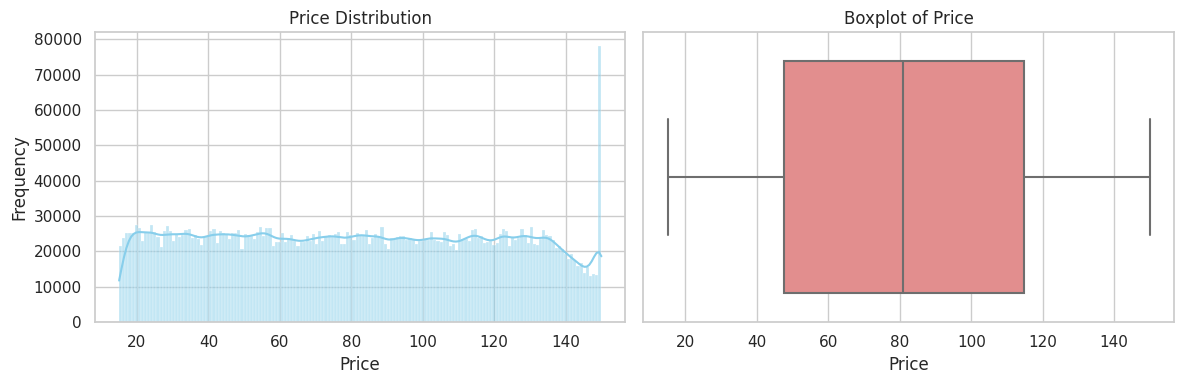

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x = train_df["Price"], kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Price Distribution")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")
sns.boxplot(x = train_df["Price"], ax=axes[1], color="lightcoral")
axes[1].set_title("Boxplot of Price")
axes[1].set_xlabel("Price")
plt.tight_layout()
plt.show()

In [8]:
price_summary = train_df["Price"].reset_index().describe().round(4).style.format(precision=2).background_gradient(cmap="Blues")
display(price_summary)

,index,Price
count,3694318.00,3694318.00
mean,1847158.50,81.36
std,1066457.89,38.93
min,0.00,15.00
25%,923579.25,47.48
50%,1847158.50,80.99
75%,2770737.75,114.84
max,3694317.00,150.00


### Target Variable Summary


**Distribution:**    
The price distribution shows a slightly right-skewed pattern, indicating that most bags are priced around the mid-range, with fewer expensive outliers. The density peak is between $40 and $120.

**Boxplot outcome:**    
The boxplot reveals the presence of outliers on the higher price end, particularly above $130. However, these are not extremely far from the general range, suggesting they may represent premium products.

**Summary Statistics:**

**Count:** 3,694,318 entries   
**Mean Price:** 81.135   
**Standard Deviation:** 38.93     
**Minimum Price:** 15   
**25th Percentile (Q1):** 47.48   
**Median (Q2):** 80.99      
**75th Percentile (Q3):** 114.84   
**Maximum Price:** 150   
The data suggests that while most bags are affordable to mid-priced, a smaller segment caters to the premium range. 

### Visualizing Numerical Columns

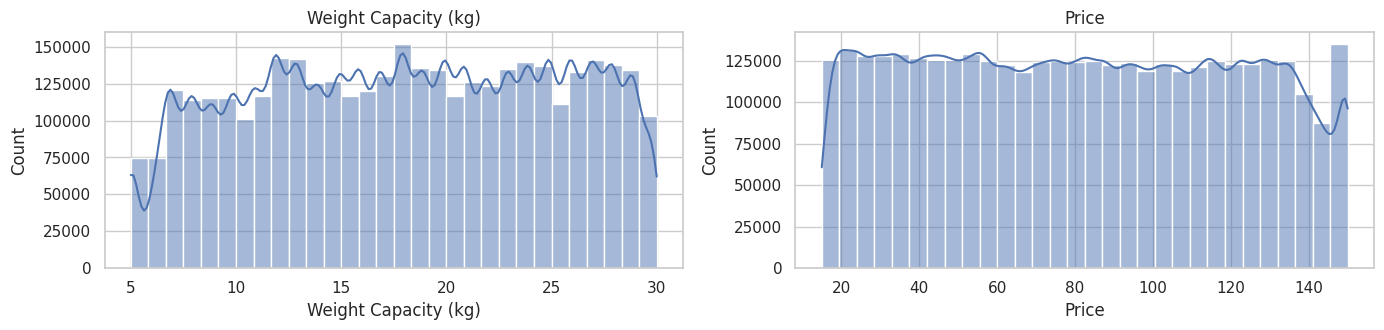

In [9]:

plt.figure(figsize=(14, len(numerical_columns_train)*3))
for i , col in enumerate(numerical_columns_train):
    plt.subplot(len(numerical_columns_train)//2+1,2,i+1)
    sns.histplot(x=col, data=train_df, bins=30, kde=True, palette="pastel")
    plt.title(col)
    plt.tight_layout()

### Visualizing Outliers in Numerical Columns

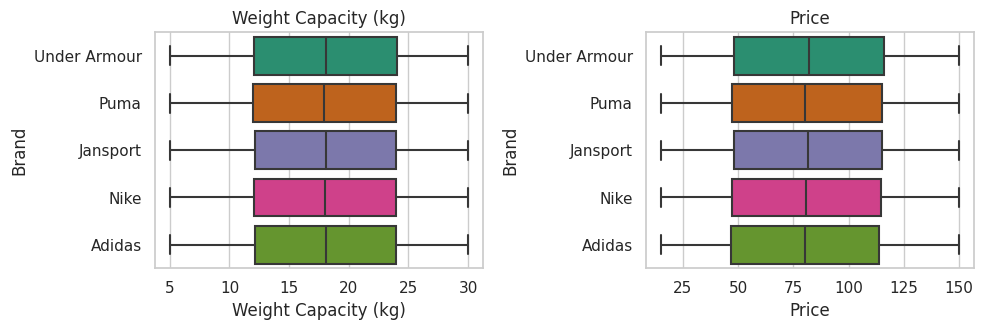

In [10]:

plt.figure(figsize=(10, 6))
for i , col in enumerate(numerical_columns_train,1):
    plt.subplot(2,2,i)
    sns.boxplot(x=col, y = "Brand", data=train_df, palette="Dark2")
    plt.title(col)
    plt.tight_layout()

The box plot of the price distribution has been generated successfully, confirming the absence of outliers visually.

### Visualizing Categorical Columns

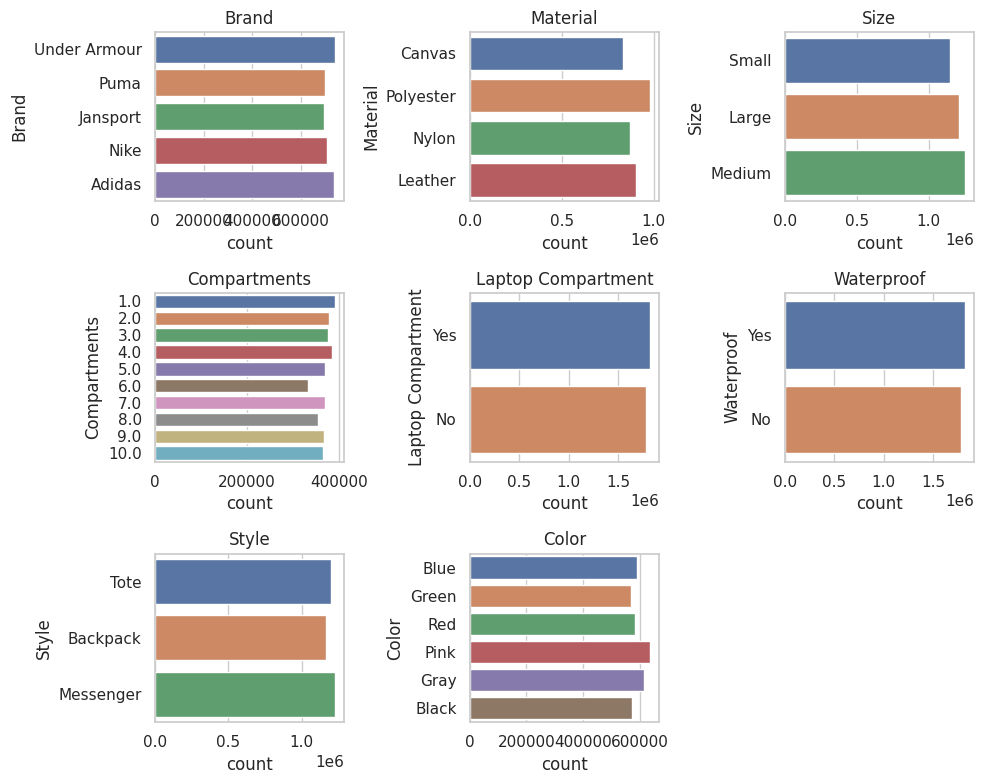

In [11]:

plt.figure(figsize=(10,8))
for i ,col in enumerate(categorical_columns_train ,1):
    plt.subplot(3,3,i)
    sns.countplot(y=col, data=train_df)
    plt.title(col)
    
plt.tight_layout()
plt.show()


### Lower Triangle Correlation Matrix of Numerical Features

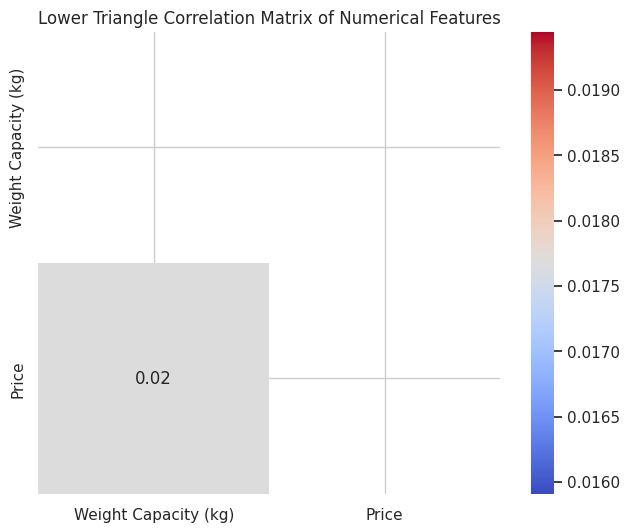

In [12]:
corr_matrix = train_df[numerical_columns_train].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Lower Triangle Correlation Matrix of Numerical Features")
plt.show()


### Analyzing the relationship between Price and Weight Capacity (kg)

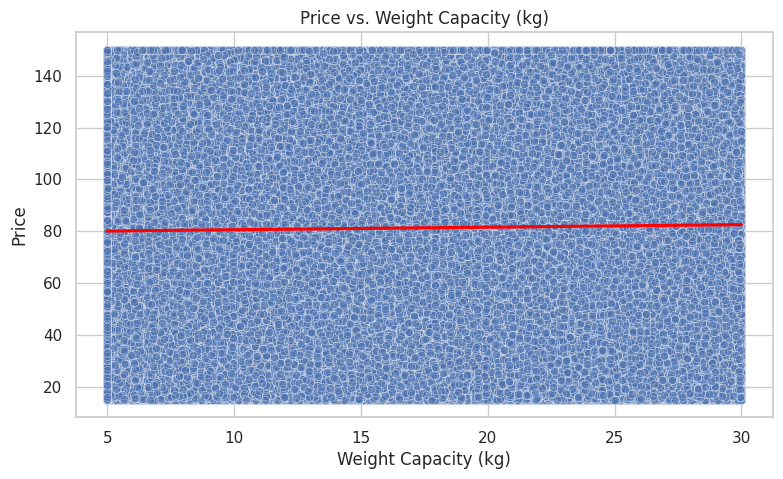

0.01767707799557337

In [13]:

plt.figure(figsize=(9, 5))
sns.scatterplot(x="Weight Capacity (kg)", y="Price", data=train_df, alpha=0.5)
sns.regplot(
    x="Weight Capacity (kg)", y="Price", data=train_df, scatter=False, color="red"
)

plt.title("Price vs. Weight Capacity (kg)")
plt.xlabel("Weight Capacity (kg)")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# Correlation calculation
correlation = train_df["Price"].corr(train_df["Weight Capacity (kg)"])
correlation

### Mean price by categorical features

In [14]:
train_df.groupby(by=categorical_columns_train)["Price"].mean().reset_index().describe(
    include="all"
).round(2).style.format(precision=2).background_gradient(cmap="Blues")

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Price
count,43200,43200,43200,43200.00,43200,43200,43200,43200,43200.00
unique,5,4,3,nan,2,2,3,6,nan
top,Adidas,Canvas,Large,nan,No,No,Backpack,Black,nan
freq,8640,10800,14400,nan,21600,21600,14400,7200,nan
mean,nan,nan,nan,5.50,nan,nan,nan,nan,81.49
std,nan,nan,nan,2.87,nan,nan,nan,nan,4.84
min,nan,nan,nan,1.00,nan,nan,nan,nan,60.41
25%,nan,nan,nan,3.00,nan,nan,nan,nan,78.21
50%,nan,nan,nan,5.50,nan,nan,nan,nan,81.48
75%,nan,nan,nan,8.00,nan,nan,nan,nan,84.73


**Observations:**    
The Mean price ranges from 81.59 to 100.2 for these categorical features! and the SD is 5.26!
I think lets check them indivisually!

In [15]:
for i in categorical_columns_train:
    display(train_df.groupby(by=i)["Price"].mean().reset_index().describe(
    include="all").round(2).style.format(precision=2).background_gradient(cmap="Blues"))
    print("----------------------")
    print("----------------------")
    print("**********************")

,Brand,Price
count,5,5.00
unique,5,nan
top,Adidas,nan
freq,1,nan
mean,nan,81.37
std,nan,0.60
min,nan,80.52
25%,nan,81.21
50%,nan,81.28
75%,nan,81.78


----------------------
----------------------
**********************


,Material,Price
count,4,4.00
unique,4,nan
top,Canvas,nan
freq,1,nan
mean,nan,81.35
std,nan,0.70
min,nan,80.49
25%,nan,80.93
50%,nan,81.44
75%,nan,81.86


----------------------
----------------------
**********************


,Size,Price
count,3,3.00
unique,3,nan
top,Large,nan
freq,1,nan
mean,nan,81.42
std,nan,0.21
min,nan,81.19
25%,nan,81.33
50%,nan,81.47
75%,nan,81.54


----------------------
----------------------
**********************


,Compartments,Price
count,10.00,10.00
mean,5.50,81.36
std,3.03,0.45
min,1.00,80.27
25%,3.25,81.23
50%,5.50,81.54
75%,7.75,81.64
max,10.00,81.72


----------------------
----------------------
**********************


,Laptop Compartment,Price
count,2,2.00
unique,2,nan
top,No,nan
freq,1,nan
mean,nan,81.38
std,nan,0.05
min,nan,81.34
25%,nan,81.36
50%,nan,81.38
75%,nan,81.40


----------------------
----------------------
**********************


,Waterproof,Price
count,2,2.00
unique,2,nan
top,No,nan
freq,1,nan
mean,nan,81.42
std,nan,0.01
min,nan,81.41
25%,nan,81.42
50%,nan,81.42
75%,nan,81.42


----------------------
----------------------
**********************


,Style,Price
count,3,3.00
unique,3,nan
top,Backpack,nan
freq,1,nan
mean,nan,81.34
std,nan,0.17
min,nan,81.17
25%,nan,81.26
50%,nan,81.35
75%,nan,81.43


----------------------
----------------------
**********************


,Color,Price
count,6,6.00
unique,6,nan
top,Black,nan
freq,1,nan
mean,nan,81.35
std,nan,0.73
min,nan,80.31
25%,nan,80.94
50%,nan,81.30
75%,nan,81.91


----------------------
----------------------
**********************


#### Nothing we can do for now! lets move ahead

<p style="background-color:#ece9e5; font-family:newtimeroman;color:#000000; font-size:30px; text-align:left; border-radius: 5px 5px;">&#128679 Feature Engineering </p>

I will:   
1.	Encode categorical variables using one-hot encoding.   
2.  Create a new feature "Weight_Class".     
3.	Split the data into features and the target variable (Price).   
4.	Create training and testing sets for the model.
Let’s proceed with encoding the categorical variables.   

In [16]:
def preproc(df):
    
    median_weight = df["Weight Capacity (kg)"].median()
    df["Weight Capacity (kg)"] = (
        df["Weight Capacity (kg)"].fillna(median_weight)
    )
    
    conditions = [
        (df["Weight Capacity (kg)"] <= 5),
        (df["Weight Capacity (kg)"]  > 5) & (df["Weight Capacity (kg)"] <= 15),
        (df["Weight Capacity (kg)"]  > 15) & (df["Weight Capacity (kg)"] <= 20),
        (df["Weight Capacity (kg)"]  > 20) & (df["Weight Capacity (kg)"] <= 25),
        (df["Weight Capacity (kg)"] > 25)
    ]
    choices = ['Light', 'Middle', 'Light_heavy', 'Middel_heavy','Heavy']
    df['Weight_Class'] = np.select(conditions, choices, default='')
    
    df["Weight Capacity (kg)"] = df["Weight Capacity (kg)"].astype("float64")
    df['Weight_Class'] = df['Weight_Class'].astype("category")
    df[categorical_columns_train] = df[categorical_columns_train].fillna("None")
    df[categorical_columns_train] = df[categorical_columns_train].astype("category")


    return df
 

In [17]:
train_df = preproc(train_df)

###########################

test_df = preproc(test_df)

###########################

train_df_xgb = pd.get_dummies(train_df, columns=categorical_columns_train, drop_first=True, dtype=int).copy()
test_df_xgb = pd.get_dummies(test_df, columns=categorical_columns_train, drop_first=True, dtype=int).copy()

<p style="background-color:#ece9e5; font-family:newtimeroman;color:#602F44; font-size:60px; text-align:center; border-radius: 5px 5px;"> &#128476 Models </p>


<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color: #b45f06; font-size:30px; text-align:left;padding: 0px; border-bottom: 3px solid #003300">Split Data</p>

### Prepare the features (X) and target (y)

In [18]:
X = train_df_xgb.drop(columns=["Price"], axis =1)
y = train_df_xgb["Price"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = SEED)

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color: #000000; font-size:30px; text-align:left;padding: 0px; border-bottom: 3px solid #003300">XGBoost Regressor</p>

<div style="border-radius:10px; border:#a1d4d2 solid; padding: 15px; background-color: #ece9e5; font-size:100%; text-align:left">

<h3 align="left"><font color="#000000"> &#128186  Hyperparameter Tuning | Xgboost</font></h3>


In [20]:
def objective_xg(trial):

    params = {
        "n_estimators": 70,
        "eval_metric": "rmse",
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        "min_child_weight": trial.suggest_int("min_child_weight", 0.01, 1),
        "subsample": trial.suggest_loguniform("subsample", 0.1, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.1, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 1)
    }

    # Initialize and fit the model
    model_xgb =  XGBRegressor(**params,
                             enable_categorical = True)
    
    model_xgb.fit(X_train, y_train)

    # Predict
    y_pred = model_xgb.predict(X_test)
    
    return mean_squared_error(y_test, y_pred, squared = False)

### Create a study object and perform optimization

In [21]:
study_xgb = optuna.create_study(direction="minimize")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(objective_xg, n_trials=5, show_progress_bar=True)

[I 2025-02-07 10:16:50,700] A new study created in memory with name: no-name-463b22f4-2c68-468e-88a5-f8013b0ea738


  0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
print("Best trail:", study_xgb.best_trials)

Best trail: [FrozenTrial(number=1, state=TrialState.COMPLETE, values=[38.92392370578651], datetime_start=datetime.datetime(2025, 2, 7, 10, 17, 4, 212232), datetime_complete=datetime.datetime(2025, 2, 7, 10, 17, 25, 938133), params={'max_depth': 7, 'learning_rate': 0.025378441775558407, 'min_child_weight': 0, 'subsample': 0.26554452027921716, 'colsample_bylevel': 0.6462932442246043, 'colsample_bytree': 0.5892369474066069, 'colsample_bynode': 0.6949487153098205, 'reg_alpha': 0.29968622282473095, 'reg_lambda': 0.4818424530339253}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=7, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'min_child_weight': IntDistribution(high=1, log=False, low=0, step=1), 'subsample': FloatDistribution(high=1.0, log=True, low=0.1, step=None), 'colsample_bylevel': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'colsample_bytree': FloatDistr

### Print the best parameters

In [23]:
print("Best parameters:", study_xgb.best_params)

Best parameters: {'max_depth': 7, 'learning_rate': 0.025378441775558407, 'min_child_weight': 0, 'subsample': 0.26554452027921716, 'colsample_bylevel': 0.6462932442246043, 'colsample_bytree': 0.5892369474066069, 'colsample_bynode': 0.6949487153098205, 'reg_alpha': 0.29968622282473095, 'reg_lambda': 0.4818424530339253}


### Feature importance | XGBoost Model

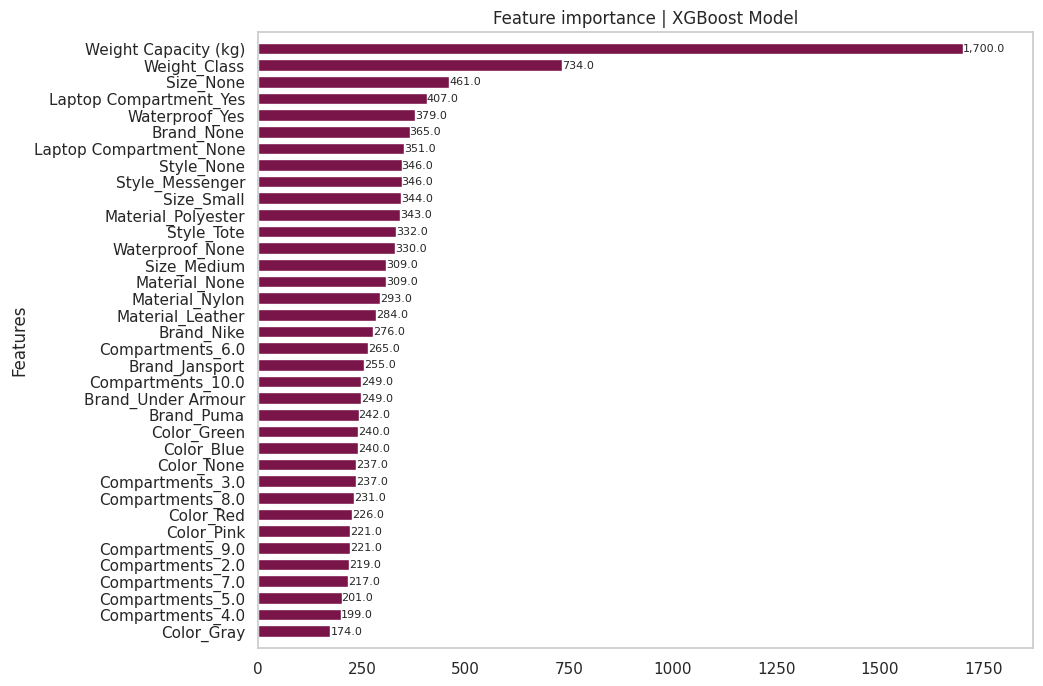

In [24]:
xgb = XGBRegressor(**study_xgb.best_params,
                   n_estimators = 100,
                   eval_metric = "rmse",
                   enable_categorical = True)

xgb.fit(X_train, y_train)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = plot_importance(
    xgb,
    show_values=False,
    title= "Feature importance | XGBoost Model",
    ax=ax,
    xlabel="",
    height=0.7,
    color="#7a1549",
)
ax.bar_label(ax.containers[0], fmt="{:,.01f}", fontsize = 8)
ax.grid(False)

plt.show()

<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color: #000000; font-size:30px; text-align:left;padding: 0px; border-bottom: 3px solid #003300">CatBoost Regressor</p>

### Data Preparation

In [25]:
train_df[categorical_columns_train] = train_df[categorical_columns_train].astype("string")
train_df[["Weight Capacity (kg)","Weight_Class"]] = train_df[["Weight Capacity (kg)","Weight_Class"]] .astype("string")
test_df = test_df.astype("string").copy()

X = train_df.drop("Price", axis=1)
y = train_df.Price

### Best Parameters | Tuned | Optuna

In [26]:
cat_best_params = {
    "learning_rate": 0.13049599324463432,
    "l2_leaf_reg": 2.955347344462475,
    "depth": 6,
}

### Cross Validation and FIT

In [27]:
kfold_cv = KFold(15, shuffle=True, random_state=SEED)
scores = []
test_preds = []
feature_importances = []
X_test_pool = Pool(test_df, cat_features=X.columns.values)

for train_idx, val_idx in kfold_cv.split(X, y):
    model = CatBoostRegressor(
        **cat_best_params,
        iterations=500,
        loss_function="RMSE",
        eval_metric="RMSE",
        random_seed=SEED,
    )
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X.columns.values)
    X_valid_pool = Pool(X_val_fold, y_val_fold, cat_features=X.columns.values)

    model.fit(
        X_train_pool, eval_set=X_valid_pool, early_stopping_rounds=200, verbose=False
    )
    feature_importances.append(model.get_feature_importance())

    val_pred = model.predict(X_valid_pool)
    score = mean_squared_error(y_val_fold, val_pred, squared = False)
    scores.append(score)

    test_pred = model.predict(X_test_pool)
    test_preds.append(test_pred)

print(f"Mean RMSE score: {np.mean(scores):.3f}")

Mean RMSE score: 38.691


### Most Important Features - CatBoost Model

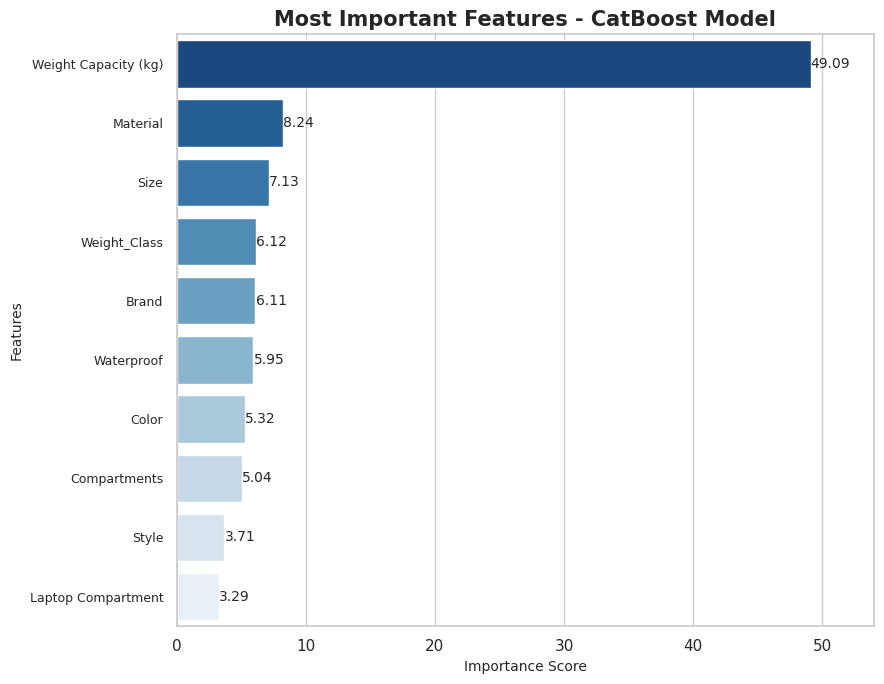

In [28]:
avg_importance = np.mean(feature_importances, axis=0)
feat_imp_df = pd.DataFrame({"Feature": X.columns, "Importance": avg_importance})
top_features = feat_imp_df.sort_values(by="Importance", ascending=False).head(10)
sns.set_style("whitegrid")
palette = sns.color_palette("Blues_r", len(top_features))
plt.figure(figsize=(9, 7))
ax = sns.barplot(x="Importance", y="Feature", data=top_features, palette=palette)
plt.title("Most Important Features - CatBoost Model", fontsize=15, fontweight="bold")
plt.xlabel("Importance Score", fontsize=10)
plt.ylabel("Features", fontsize=10)
for i, v in enumerate(top_features["Importance"]):
    ax.text(v + 0.01, i, f"{v:.2f}", va="center", fontsize=10)


plt.xlim(0, max(top_features["Importance"]) * 1.1)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

<p style="background-color:#485977; font-family:newtimeroman;color:#ffffff; font-size:40px; text-align:center; border-radius: 5px 5px;"> CatBoost | Prediction &#128591</p>


### Prediction and Submission 

In [29]:
sample_submission["Price"] = np.mean(test_preds, axis=0)
sample_submission.to_csv("submission.csv", index=False)
sample_submission

,id,Price
0,300000,79.249603
1,300001,82.134902
2,300002,82.180839
3,300003,76.630077
4,300004,80.516970
...,...,...
199995,499995,84.083154
199996,499996,85.252150
199997,499997,82.660668
199998,499998,82.226103


### Submission | Price Distribution

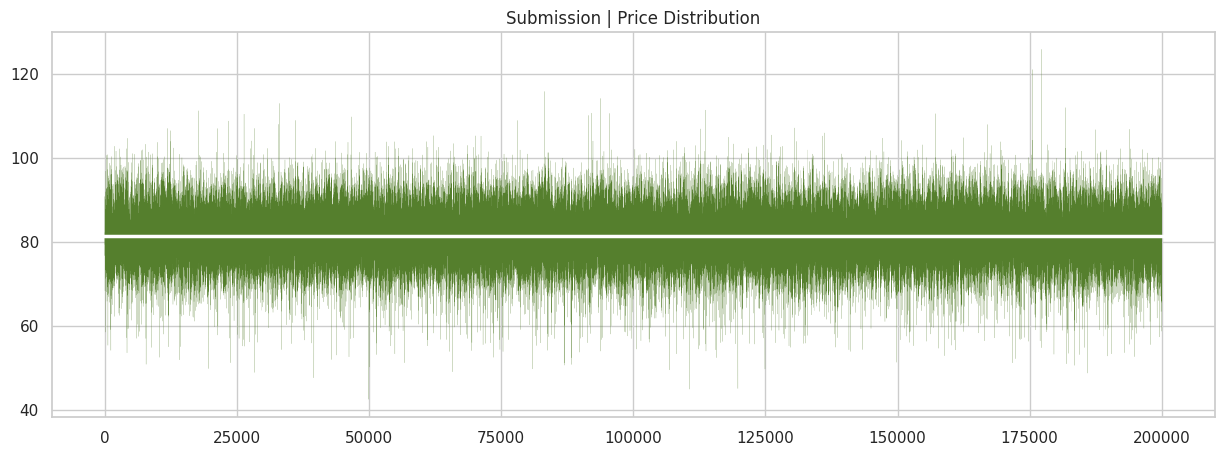

In [30]:
plt.figure(figsize=(15, 5))
sample_submission["Price"].plot(
    color="#557f2d", linewidth=0.1, title="Submission | Price Distribution"
)
plt.axhline(sample_submission["Price"].mean(), c="w", ls="-", lw=2.5)
plt.show()

### Next 

I will consider potential improvements, such as:   

•	More feature eng.  
•	More data transformation strategy.   
•	ModelsEnhancement .   
•	Performing feature selection or engineering to enhance the model’s performance.  
•	ETC.

#### Stay Tuned! Your support is highly appreciated!